In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

import env
import zillow_wrangle
import split_scale
import evaluate
import explore
import feature

# Data Science Pipeline

### Acquire
*Goal: Having a clean dataframe ready to prepare*

#### - I'm acquiring my data using wrangle_zillow

In [2]:
df = zillow_wrangle.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 16 columns):
id                              20778 non-null int64
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
fips                            20778 non-null float64
rawcensustractandblock          20778 non-null float64
regionidcounty                  20778 non-null float64
roomcnt                         20778 non-null float64
structuretaxvaluedollarcnt      20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
assessmentyear                  20778 non-null float64
landtaxvaluedollarcnt           20778 non-null float64
taxamount                       20778 non-null float64
id                              20778 non-null int64
logerror                        20778 non-null float64
transactiondate                 20778 non-null object
dtypes: float64(

### Hypothesis:
- $H_0$: Number of bathrooms and bedrooms in home, as well as square footage will not be leading factors in predicting property value
- $H_a$: Number of bathrooms, bedrooms and square footage will have a strong reciprocy for predicting property value.
- $H_a$: Using recursive feature elimination from SK.learn will proove a different variation of features that will predict features mentioned above but not discluding other possible features included in the dataset

### Prep
*Goal: leave this section with a dataset that is split into train and test ready to be analyzed. Data types are appropriate, missing values have been addressed, as have any data integrity issues.*

##### After a bit of exploring, I noticed that every fip code was for a county in california , added that as the state

In [4]:
state = 'California'
df['State'] = state
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California


#### There are only 3 unique fips numbers, so I added these to a seperate column called 'county'.

In [5]:
df.fips.unique()

array([6037., 6059., 6111.])

#### small for loop to convert fips to counties

In [6]:
county = []

for row in df['fips']:
    if row == 6037:
        county.append('Los Angelas')
    elif row == 6059:
        county.append('Orange')
    elif row == 6111:
        county.append('Ventura')
        
df['county'] = county        

In [7]:
df.groupby('county').count()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State
county,,,,,,,,,,,,,,,,,
Los Angelas,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269,13269
Orange,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812,5812
Ventura,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697,1697


#### Creating a new column called tax_rate which is the amount taxed divided by the home value to give us the percentage taxed.

In [8]:
df['tax_rate'] = df.taxamount / df.taxvaluedollarcnt

df['tax_rate'] = df.tax_rate.round(3)

### plotting the tax distribution

In [9]:
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State,county,tax_rate
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California,Los Angelas,0.017
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California,Los Angelas,0.015
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California,Orange,0.011
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California,Los Angelas,0.012
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California,Los Angelas,0.012


In [10]:
county_df = df[['county', 'tax_rate']]
county_df.head()

,county,tax_rate
0,Los Angelas,0.017
1,Los Angelas,0.015
2,Orange,0.011
3,Los Angelas,0.012
4,Los Angelas,0.012


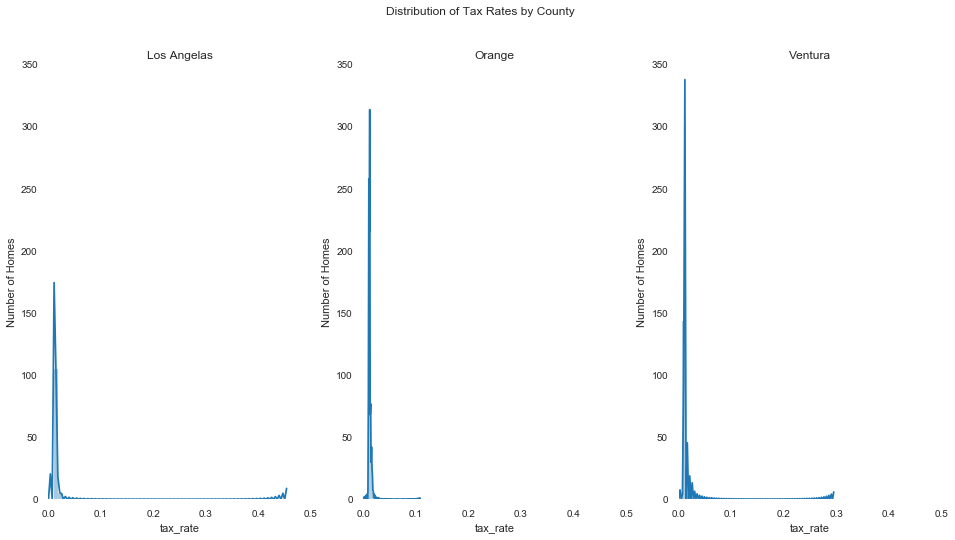

In [11]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.5)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.5)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.5)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.show()

## There are some crazy outliers in the Los Angelas and Ventura counties. I will show the distribution by cutting those outliers from the data, as they are heavily influencing the shape of the distribution.

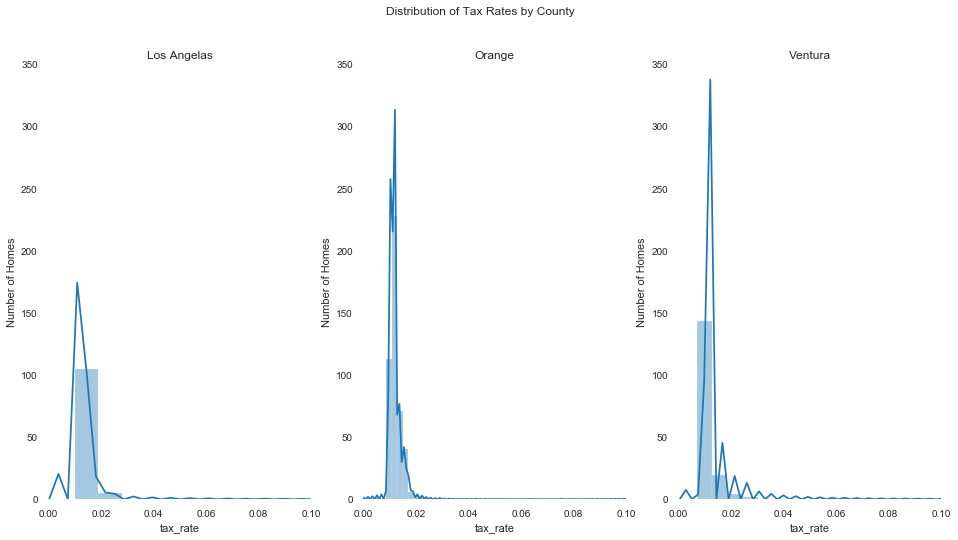

In [12]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.1)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.1)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.1)
plt.ylim(0, 350)
plt.ylabel("Number of Homes")

plt.show()

The ad hoc part includes plotting the distributions of individual variables and using those plots to identify outliers and if those should be handled (and if so, how), identify unit scales to identify how to best scale the numeric data, as well as finding erroneous or invalid data that may exist in your dataframe.

### visualizing Data for pre-exploration

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 19 columns):
id                              20778 non-null int64
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
fips                            20778 non-null float64
rawcensustractandblock          20778 non-null float64
regionidcounty                  20778 non-null float64
roomcnt                         20778 non-null float64
structuretaxvaluedollarcnt      20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
assessmentyear                  20778 non-null float64
landtaxvaluedollarcnt           20778 non-null float64
taxamount                       20778 non-null float64
id                              20778 non-null int64
logerror                        20778 non-null float64
transactiondate                 20778 non-null object
State           

### a lot of these parameters aren't viable features for our model, so I wittled it down to 4 possible features and our target variable

In [14]:
bed_bath_and_beyond = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [15]:
bed_bath_and_beyond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 5 columns):
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
roomcnt                         20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
dtypes: float64(5)
memory usage: 974.0 KB


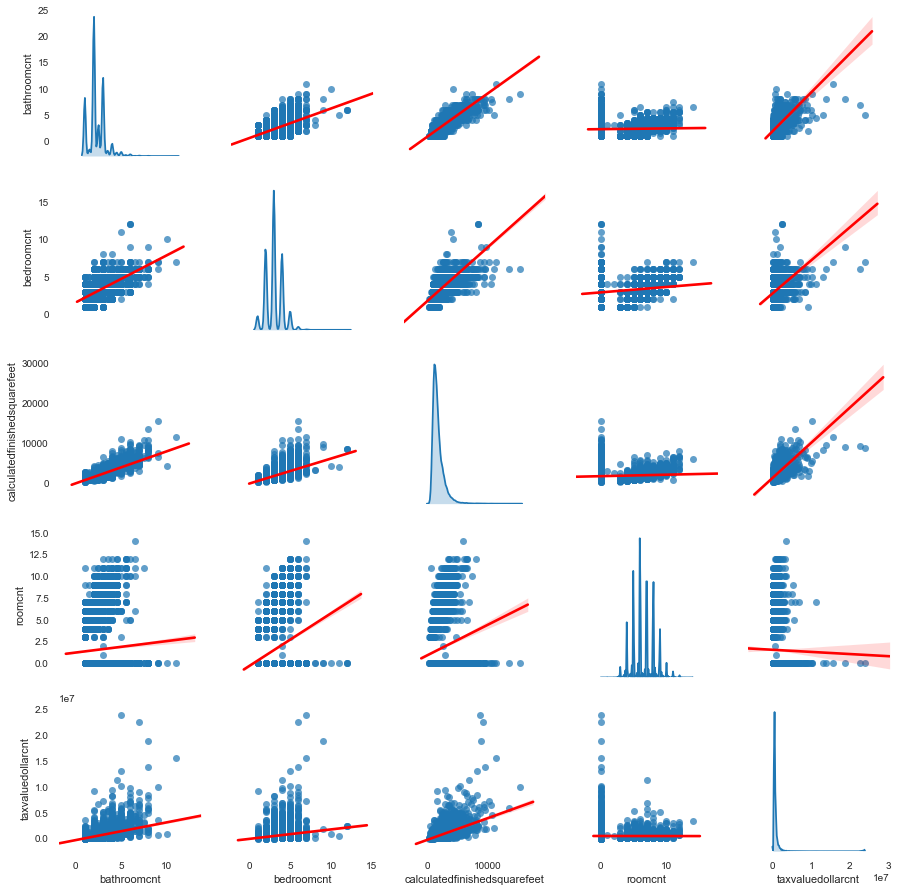

In [16]:
explore.plot_variable_pairs(bed_bath_and_beyond)

Add a data dictionary in your notebook that defines all fields used in your model and your analysis, and answers the question: why did you use the fields you used, e.g. why did you use bedroom_field1 over bedroom_field2, not why did you use number of bedrooms!

#### splitting our data

In [17]:
train, test = split_scale.split_my_data(df)

### Data Exploration
Goal: Address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, answers to specific questions your customers has asked, and information to move forward toward building a model.

Run at least 1 t-test and 1 correlation test (but as many as you need!)
Visualize all combinations of variables in some way(s).
What independent variables are correlated with the dependent?
Which independent variables are correlated with other independent variables?
Make sure to summarize your takeaways and conclusions. That is, the data science zillow team doesn't want to see just a bunch of dataframes/numbers/charts without any explanation, you should explain in the notebook what these dataframes/numbers/charts mean.

### using ***pearson's r*** to test correlation

#### testing for bathroom count & property value

In [18]:
x = df.bathroomcnt
y = df.taxvaluedollarcnt 

corr, p = stats.pearsonr(x, y)
corr, p

(0.5038602849897236, 0.0)

#### Here we visualize our findings

In [19]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between bedroom count and property value

In [20]:
x = df.bedroomcnt

corr, p = stats.pearsonr(x, y)
corr, p

(0.28346035958830285, 0.0)

#### Visuals for our correlation

In [21]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between square footage and property value

In [22]:
x = df.calculatedfinishedsquarefeet

corr, p = stats.pearsonr(x, y)
corr, p

(0.6045735994042187, 0.0)

#### visuals

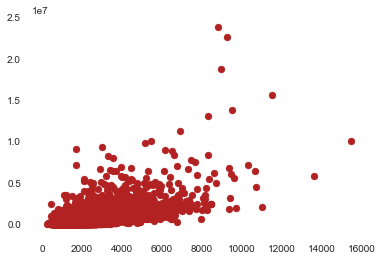

In [23]:
plt.scatter(x, y, c='firebrick')
plt.show()

#### testing correlation between room count and property value

In [24]:
x = df.roomcnt

corr, p = stats.pearsonr(x, y)
corr, p

(-0.005461113151352347, 0.4311912453343949)

#### visuals

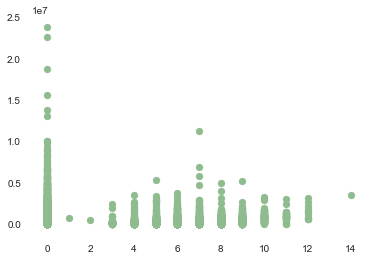

In [25]:
plt.scatter(x, y, c="darkseagreen")
plt.show()

### Modeling
Goal: develop a regression model that performs better than a baseline.

In [26]:
train = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]
test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [27]:
train.taxvaluedollarcnt.sort_values(ascending=False)

4768     23858374.0
13310    22589311.0
8023     18812604.0
5358     15623925.0
1632     13852918.0
            ...    
3778        16514.0
12191       16084.0
15655       15692.0
16799       14284.0
8025        10504.0
Name: taxvaluedollarcnt, Length: 16622, dtype: float64

In [28]:
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train[['taxvaluedollarcnt']]
X_test = test.drop(columns=['taxvaluedollarcnt'])
y_test = test[['taxvaluedollarcnt']]

#### developing baseline model

In [29]:
predictions = pd.DataFrame()

predictions['actual'] = y_train['taxvaluedollarcnt']
predictions['baseline'] = y_train['taxvaluedollarcnt'].mean()

In [30]:
predictions.head()

,actual,baseline
8527,36031.0,504794.004933
2882,479197.0,504794.004933
4969,397887.0,504794.004933
955,403190.0,504794.004933
2061,333709.0,504794.004933


#### Evaluate baseline model,

In [31]:
evaluate.baseline_mean_errors(predictions.actual)

{'sse': 7396280284606807.0,
 'mse': 444969334893.92413,
 'rmse': 667060.2183415858}

##### These numbers are terrible...

### model # 1

### Now we're going to do a linear regression model using Recursive Feature Elimination from Scikit learn

- feature elimination

In [32]:
X_train.info(), y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16622 entries, 8527 to 11351
Data columns (total 4 columns):
bathroomcnt                     16622 non-null float64
bedroomcnt                      16622 non-null float64
calculatedfinishedsquarefeet    16622 non-null float64
roomcnt                         16622 non-null float64
dtypes: float64(4)
memory usage: 649.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16622 entries, 8527 to 11351
Data columns (total 1 columns):
taxvaluedollarcnt    16622 non-null float64
dtypes: float64(1)
memory usage: 259.7 KB


(None, None)

In [33]:
# Initialize the Linear Regression Object 
lm = LinearRegression()
rfe = RFE(lm, 3)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#### we have our 3 features from sklearn

In [34]:
#boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 3 features: bathroomcnt, bedroomcnt, roomcnt


In [35]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-287787.00581655]
features:  Index(['bathroomcnt', 'bedroomcnt', 'roomcnt'], dtype='object')
coefficients:  [[358812.0165477   -9435.89749856  -5471.19409123]]


In [37]:
predictions['model1'] = lm.predict(X_rfe)

In [38]:
predictions.head()

,actual,baseline,model1
8527,36031.0,504794.004933,52153.215734
2882,479197.0,504794.004933,52153.215734
4969,397887.0,504794.004933,769777.248829
955,403190.0,504794.004933,553579.372601
2061,333709.0,504794.004933,52153.215734


#### now we're grabbing our regression errors

In [39]:
evaluate.regression_errors(predictions.actual, predictions.model1)

,metric,model_values
0,SSE,5.521487e+15
1,ESS,1.874794e+15
2,TSS,7.396280e+15
3,MSE,3.321794e+11
4,RMSE,5.763501e+05
5,R^2,2.534779e-01


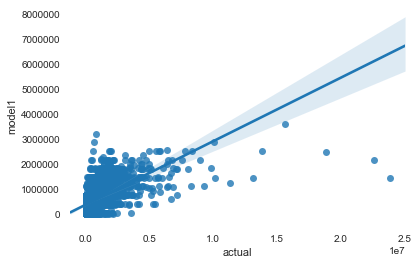

In [40]:
sns.regplot(predictions.actual, predictions.model1)

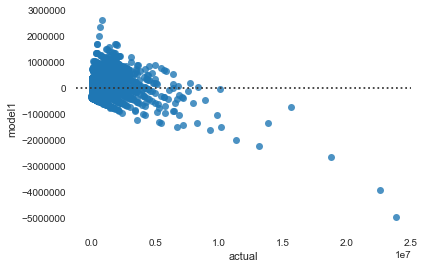

In [41]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model1)

### Ran on our test, data

In [42]:
model_predictions = pd.DataFrame()

model_predictions['actual'] = y_test['taxvaluedollarcnt']

model1 = lm.predict(test[['bathroomcnt', 'bedroomcnt', 'roomcnt']])

model_predictions['model1'] = model1

#### evaluating our test data with the regression errors and plotting our residuals

In [43]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model1)

,metric,model_values
0,SSE,9.690524e+14
1,ESS,4.620801e+14
2,TSS,1.311624e+15
3,MSE,2.331695e+11
4,RMSE,4.828763e+05
5,R^2,3.522962e-01


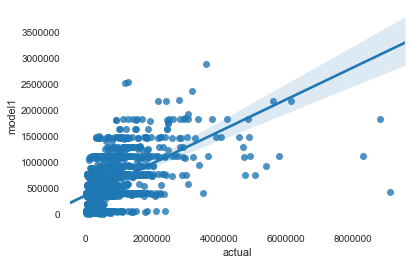

In [44]:
sns.regplot(model_predictions.actual, model_predictions.model1)

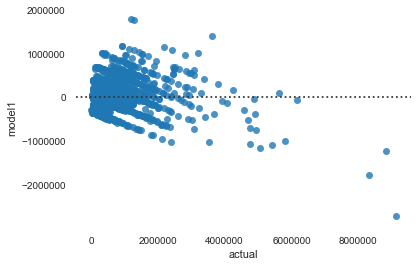

In [45]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model1)

### Model 2 we will do a linear regression model after selecting features from SelectKBest

In [46]:
# We are initializing ourf_selector object
f_selector = SelectKBest(f_regression, k=2)

# fitting the object to our data 
f_selector.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x126d96a70>)

In [47]:
# transforming our dataset to reduce kbest features
X_reduced = f_selector.transform(X_train)

f_support = f_selector.get_support()

f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['bathroomcnt', 'calculatedfinishedsquarefeet']


In [48]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
# Fitting the data to model
K_best_train = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet']]
lm.fit(K_best_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", f_feature)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-285009.47480356]
features:  ['bathroomcnt', 'calculatedfinishedsquarefeet']
coefficients:  [[25983.94644633   408.41655671]]


In [51]:
predictions['model2'] = lm.predict(K_best_train)

In [52]:
predictions.head()

,actual,baseline,model1,model2
8527,36031.0,504794.004933,52153.215734,113450.371364
2882,479197.0,504794.004933,52153.215734,49737.388517
4969,397887.0,504794.004933,769777.248829,350022.547890
955,403190.0,504794.004933,553579.372601,366028.150194
2061,333709.0,504794.004933,52153.215734,49737.388517


In [53]:
evaluate.regression_errors(predictions.actual, predictions.model2)

,metric,model_values
0,SSE,4.698417e+15
1,ESS,2.697863e+15
2,TSS,7.396280e+15
3,MSE,2.826626e+11
4,RMSE,5.316602e+05
5,R^2,3.647595e-01


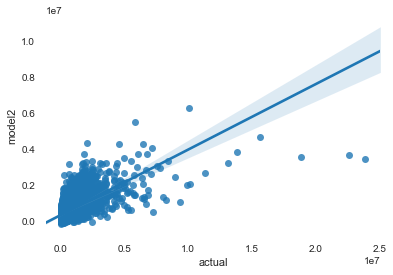

In [54]:
sns.regplot(predictions.actual, predictions.model2)

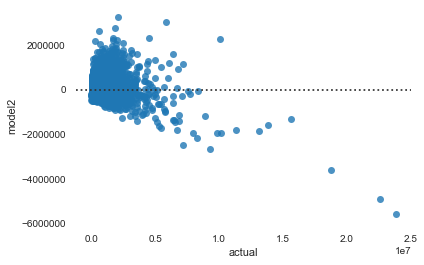

In [55]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model2)

### Ran on our test data

In [56]:
model2 = lm.predict(test[['bathroomcnt', 'calculatedfinishedsquarefeet']])

model_predictions['model2'] = model2

#### evaluating our regression errors & plotting our residuals

In [57]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model2)

,metric,model_values
0,SSE,8.246945e+14
1,ESS,6.642307e+14
2,TSS,1.311624e+15
3,MSE,1.984347e+11
4,RMSE,4.454601e+05
5,R^2,5.064185e-01


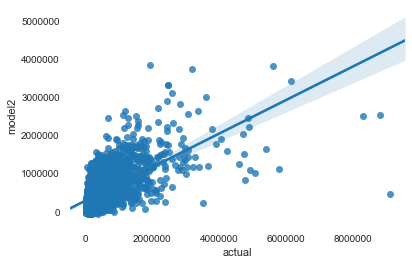

In [58]:
sns.regplot(model_predictions.actual, model_predictions.model2)

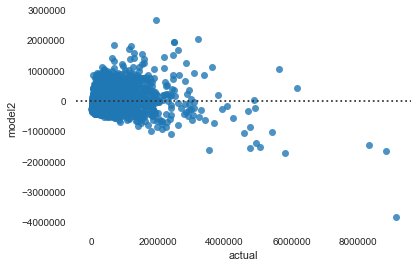

In [59]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model2)

### model 3 we will be using number of bedrooms, bathrooms and square footage to predict property value

In [60]:
X_train = X_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

In [61]:
# initializing linear regression model from sklearn
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
# Fitting the data to model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", X_train.columns)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-47499.96556248]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object')
coefficients:  [[  49765.05347132 -144314.12302522     490.81998931]]


In [64]:
predictions['model3'] = lm.predict(X_train)

predictions.head()

,actual,baseline,model1,model2,model3
8527,36031.0,504794.004933,52153.215734,113450.371364,161264.672108
2882,479197.0,504794.004933,52153.215734,49737.388517,84696.753776
4969,397887.0,504794.004933,769777.248829,350022.547890,482645.414219
955,403190.0,504794.004933,553579.372601,366028.150194,348296.983699
2061,333709.0,504794.004933,52153.215734,49737.388517,84696.753776


#### grab those regression errors

In [65]:
evaluate.regression_errors(predictions.actual, predictions.model3)

,metric,model_values
0,SSE,4.509512e+15
1,ESS,2.886768e+15
2,TSS,7.396280e+15
3,MSE,2.712978e+11
4,RMSE,5.208625e+05
5,R^2,3.903000e-01


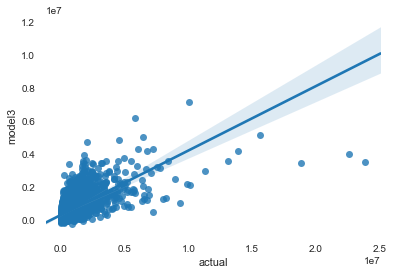

In [66]:
sns.regplot(predictions.actual, predictions.model3)

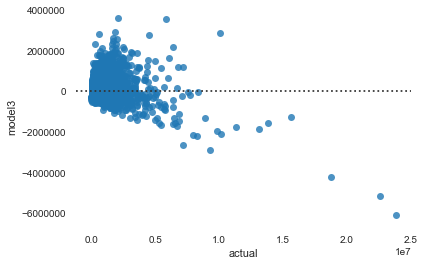

In [67]:
evaluate.plot_residuals(predictions, predictions.actual, predictions.model3)

### running our model on our test data

In [68]:
model3 = lm.predict(test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

model_predictions['model3'] = model3

#### grabbing our regression errors and plotting our residuals

In [69]:
evaluate.regression_errors(model_predictions.actual, model_predictions.model3)

,metric,model_values
0,SSE,7.746467e+14
1,ESS,6.931630e+14
2,TSS,1.311624e+15
3,MSE,1.863924e+11
4,RMSE,4.317318e+05
5,R^2,5.284769e-01


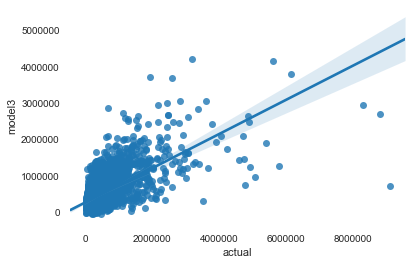

In [70]:
sns.regplot(model_predictions.actual, model_predictions.model3)

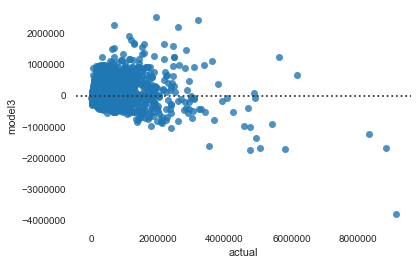

In [71]:
evaluate.plot_residuals(model_predictions, model_predictions.actual, model_predictions.model3)

### Going back to the tax distribution idea, maybe it would be a more accurate model if we split our data by county and modeled our data by county

#### I'm going to take my most accurate model, and use it on this data split by county

In [72]:
la = df[df.county == 'Los Angelas']
orange = df[df.county == 'Orange']
ventura = df[df.county == 'Ventura']

### train test data

In [73]:
# my random state for all of these is 830
la_train, la_test = split_scale.split_my_data(la)
orange_train, orange_test = split_scale.split_my_data(orange)
ventura_train, ventura_test = split_scale.split_my_data(ventura)

In [74]:
# added the actual and the baseline to my df
county_predictions = pd.DataFrame()
county_predictions['actual'] = la_train.taxvaluedollarcnt
county_predictions['baseline'] = la_train.taxvaluedollarcnt.mean()

### Los angelas

In [75]:
X_train = la_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = la_train.taxvaluedollarcnt

# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['LA'] = lm.predict(X_train)

county_predictions.head()

,actual,baseline,LA
8190,461550.0,493684.556759,853947.654517
16742,499000.0,493684.556759,428734.042376
2397,476000.0,493684.556759,225721.544126
4215,279193.0,493684.556759,581154.731790
11237,570477.0,493684.556759,859629.515868


In [76]:
# baseline errors
evaluate.baseline_mean_errors(county_predictions.actual)

{'sse': 6045068979080176.0,
 'mse': 569483653234.1193,
 'rmse': 754641.4070498114}

In [77]:
evaluate.regression_errors(county_predictions.actual, county_predictions.LA)

,metric,model_values
0,SSE,3.696141e+15
1,ESS,2.348928e+15
2,TSS,6.045069e+15
3,MSE,3.481998e+11
4,RMSE,5.900845e+05
5,R^2,3.885693e-01


Text(0, 0.5, 'Predicted Property Value')

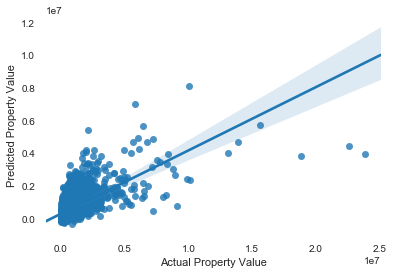

In [78]:
sns.regplot(county_predictions.actual, county_predictions.LA)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

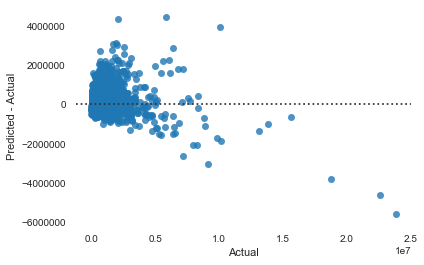

In [79]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.LA)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")

### Los Angelas test data

In [80]:
test_results = pd.DataFrame()
test_results['actual'] = la_test.taxvaluedollarcnt

In [81]:
Los_angelas = lm.predict(la_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['LA'] = Los_angelas


evaluate.regression_errors(test_results.actual, test_results.LA)

,metric,model_values
0,SSE,4.810464e+14
1,ESS,5.610367e+14
2,TSS,7.400089e+14
3,MSE,1.812533e+11
4,RMSE,4.257386e+05
5,R^2,7.581485e-01


In [82]:
4.257386 * 10**5

425738.60000000003

In [83]:
evaluate.baseline_mean_errors(test_results.actual)

{'sse': 740008947429561.5, 'mse': 278827787275.6449, 'rmse': 528041.4635950901}

Text(0, 0.5, 'Predicted Property Value')

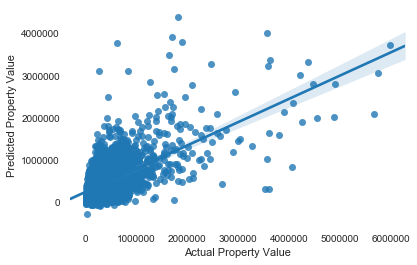

In [84]:
sns.regplot(test_results.actual, test_results.LA)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

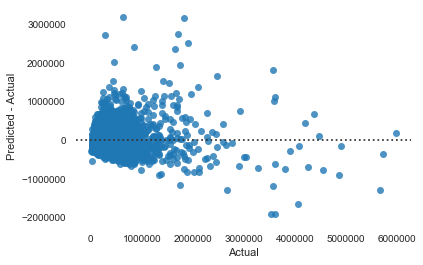

In [85]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.LA)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")

### Orange County

In [86]:
county_predictions = pd.DataFrame()
county_predictions['actual'] = orange_train.taxvaluedollarcnt

In [87]:
X_train = orange_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = orange_train.taxvaluedollarcnt

# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['orange'] = lm.predict(X_train)

county_predictions.head()

,actual,orange
12993,271954.0,313332.507800
9235,352323.0,196887.894181
17651,114464.0,404738.110205
6716,517777.0,427595.735770
2601,131000.0,769709.886524


In [88]:
evaluate.regression_errors(county_predictions.actual, county_predictions.orange)

,metric,model_values
0,SSE,8.575926e+14
1,ESS,6.650042e+14
2,TSS,1.522597e+15
3,MSE,1.844682e+11
4,RMSE,4.294976e+05
5,R^2,4.367566e-01


Text(0, 0.5, 'Predicted Property Value')

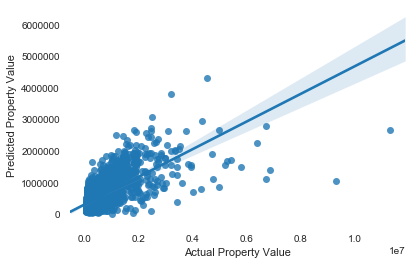

In [89]:
sns.regplot(county_predictions.actual, county_predictions.orange)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

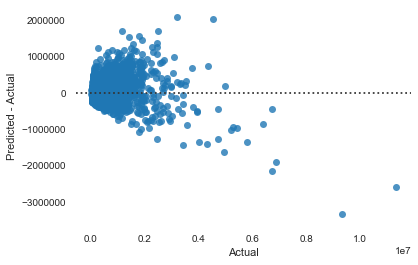

In [90]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.orange)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")

#### orange Test data

In [91]:
test_results = pd.DataFrame()
test_results['actual'] = orange_test.taxvaluedollarcnt

In [92]:
orange = lm.predict(orange_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['orange'] = orange


evaluate.regression_errors(test_results.actual, test_results.orange)

,metric,model_values
0,SSE,1.032772e+14
1,ESS,1.530353e+14
2,TSS,2.119638e+14
3,MSE,8.880239e+10
4,RMSE,2.979973e+05
5,R^2,7.219882e-01


In [93]:
2.979973 * 10**5

297997.30000000005

In [94]:
evaluate.baseline_mean_errors(test_results.actual)

{'sse': 211963766724924.94,
 'mse': 182256033297.4419,
 'rmse': 426914.5503463684}

Text(0, 0.5, 'Predicted Property Value')

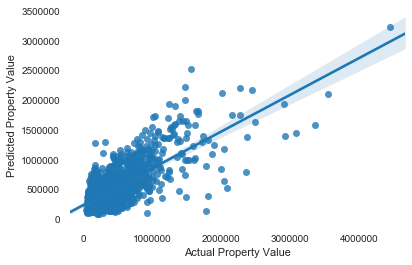

In [95]:
sns.regplot(test_results.actual, test_results.orange)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

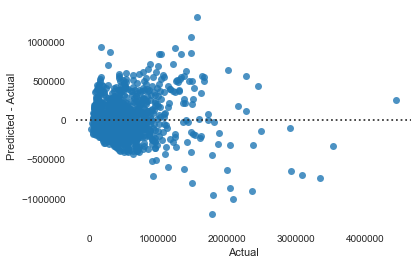

In [96]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.orange)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")

### Ventura County

In [97]:
county_predictions = pd.DataFrame()
county_predictions['actual'] = ventura_train.taxvaluedollarcnt

In [98]:
X_train = ventura_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = ventura_train.taxvaluedollarcnt

In [99]:
# initializing linear regression model from sklearn
lm = LinearRegression()
lm

# Fitting the data to model
lm.fit(X_train, y_train)


county_predictions['ventura'] = lm.predict(X_train)

county_predictions.head()

,actual,ventura
19191,64609.0,326954.555520
11590,653266.0,756214.219646
10975,458179.0,625816.438439
19755,1034497.0,860468.749918
8508,867000.0,805463.321913


In [100]:
evaluate.regression_errors(county_predictions.actual, county_predictions.ventura)

,metric,model_values
0,SSE,5.206891e+13
1,ESS,8.312245e+13
2,TSS,1.351914e+14
3,MSE,3.837060e+10
4,RMSE,1.958842e+05
5,R^2,6.148503e-01


Text(0, 0.5, 'Predicted Property Value')

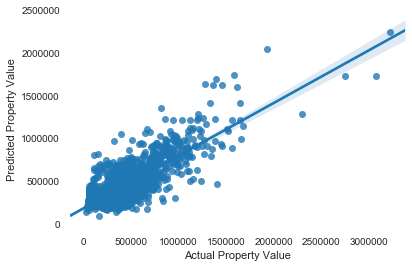

In [101]:
sns.regplot(county_predictions.actual, county_predictions.ventura)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

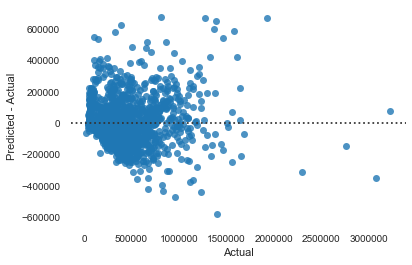

In [102]:
evaluate.plot_residuals(county_predictions, county_predictions.actual, county_predictions.ventura)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")

#### ventura test data

In [103]:
test_results = pd.DataFrame()
test_results['actual'] = ventura_test.taxvaluedollarcnt

In [104]:
ventura = lm.predict(ventura_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']])

test_results['ventura'] = ventura

evaluate.regression_errors(test_results.actual, test_results.ventura)

,metric,model_values
0,SSE,1.456850e+13
1,ESS,1.685183e+13
2,TSS,3.018705e+13
3,MSE,4.284854e+10
4,RMSE,2.069989e+05
5,R^2,5.582471e-01


In [105]:
2.069989 * 10**5

206998.9

In [106]:
evaluate.baseline_mean_errors(test_results.actual)


{'sse': 30187049400493.246,
 'mse': 88785439413.21542,
 'rmse': 297968.8564484809}

Text(0, 0.5, 'Predicted Property Value')

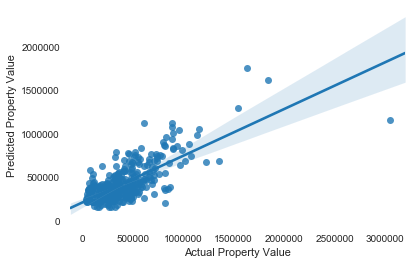

In [107]:
sns.regplot(test_results.actual, test_results.ventura)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")

Text(0, 0.5, 'Predicted - Actual')

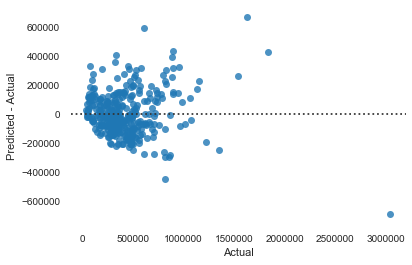

In [108]:
evaluate.plot_residuals(test_results, test_results.actual, test_results.ventura)
plt.xlabel("Actual")
plt.ylabel("Predicted - Actual")